# Facebook Prophet

In [1]:
import pandas as pd

In [2]:
springfield = pd.read_csv('data/springfield.csv')
springfield['date'] = pd.to_datetime(springfield['date'])
springfield.rename(columns={'date':'ds'}, inplace=True)
springfield

,ds,65807,65802,65804,65810,65806,65809
0,1996-04-01,80800.0,64800.0,83200.0,117900.0,38800.0,158200.0
1,1996-05-01,80800.0,64100.0,83200.0,116800.0,38500.0,158000.0
2,1996-06-01,80900.0,63500.0,83300.0,115900.0,38200.0,158000.0
3,1996-07-01,81100.0,63000.0,83500.0,115200.0,38000.0,158100.0
4,1996-08-01,81400.0,62600.0,83700.0,114800.0,37600.0,158300.0
...,...,...,...,...,...,...,...
260,2017-12-01,119900.0,94800.0,141800.0,192000.0,61000.0,257400.0
261,2018-01-01,120500.0,95400.0,141800.0,192900.0,61600.0,257500.0
262,2018-02-01,121400.0,95900.0,142800.0,195000.0,61700.0,260400.0
263,2018-03-01,122800.0,96600.0,145100.0,198000.0,62000.0,266200.0


## Baseline

In [3]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.style.use('seaborn-talk')
import warnings
warnings.filterwarnings('ignore')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=T

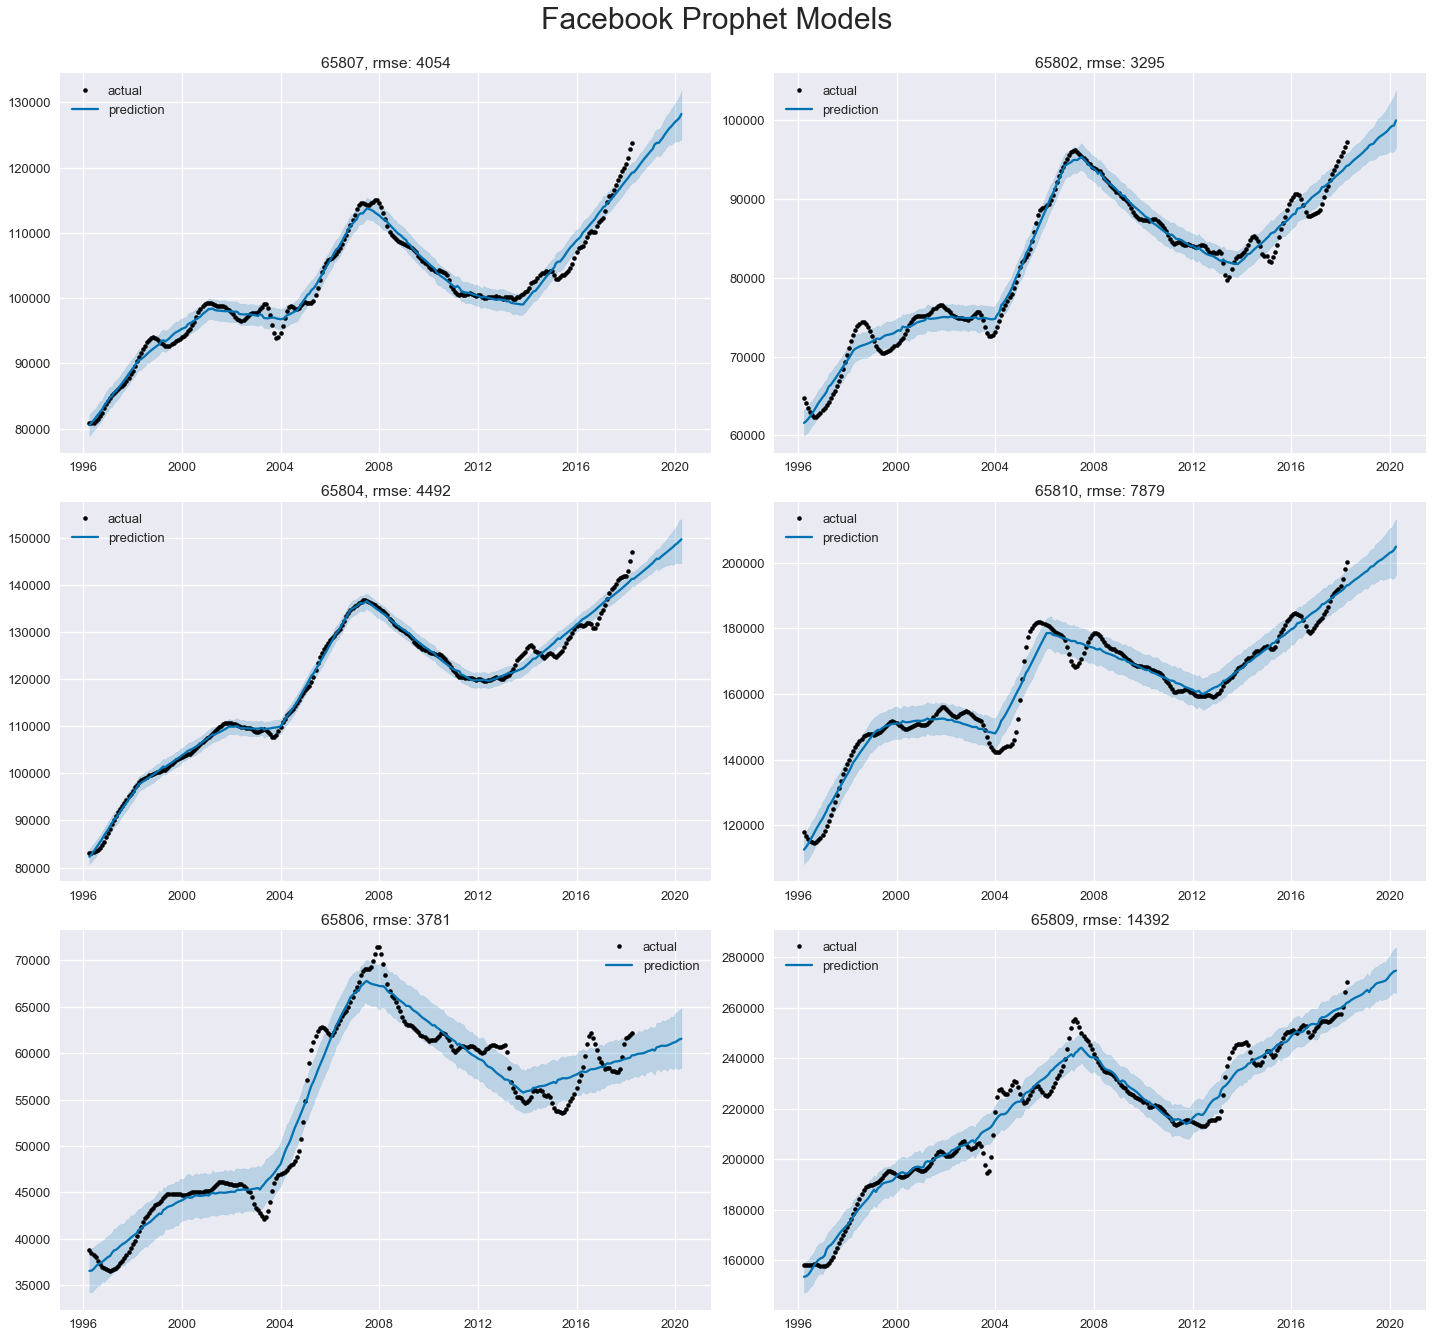

In [4]:
forecasts = {}
fig = plt.figure(figsize=(20, 18))
axs = fig.subplots(3, 2).flatten()

for i, col in enumerate(springfield.columns[1:]):
    ts = springfield[['ds', col]].rename(columns={col:'y'})
    ts_model = Prophet()
    ts_model.fit(ts)
    forecast = ts_model.predict(ts_model.make_future_dataframe(periods=24, freq='MS'))
    
    df_cv = cross_validation(ts_model, initial='15 y', period='180 days', horizon = '1 y')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmse = df_p['rmse'].values[0]
    
    forecasts[col] = forecast[['ds', 'yhat']].rename(columns={'ds':'date', 'yhat':col}).set_index('date')
    
    ax = axs[i]
    ax.plot('ds', col, 'k.', data=springfield)
    ax.plot(forecast['ds'], forecast['yhat'], ls='-', c='#0072B2')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#0072B2', alpha=0.2)
    ax.set_title(f'{col}, rmse: {int(rmse)}')
    ax.legend(labels=('actual', 'prediction'))

plt.suptitle('Facebook Prophet Models', y=1.03, fontsize=30)
plt.tight_layout()
plt.show()

In [5]:
prophet_forecasts = {i:k.values.flatten() for i, k in forecasts.items()}
prophet_forecasts['date'] = list(forecasts.values())[0].index
prophet_baseline_df = pd.DataFrame(prophet_forecasts)
prophet_baseline_df.set_index('date', inplace=True)
prophet_baseline_df

,65807,65802,65804,65810,65806,65809
date,,,,,,
1996-04-01,80524.182390,61600.421777,82295.596158,112526.038084,36536.083108,153471.728985
1996-05-01,80869.557307,61796.811998,82806.004462,113278.649378,36560.487068,153704.686167
1996-06-01,81256.484504,62094.571223,83419.383034,114262.118611,36713.681273,154265.431965
1996-07-01,81665.619932,62418.672773,84012.254980,115335.600844,36987.452743,155278.762442
1996-08-01,82068.008507,62792.135191,84671.330337,116510.038826,37210.034227,156729.019048
...,...,...,...,...,...,...
2019-12-01,126644.870344,98674.301891,148020.254925,202551.754958,61124.717393,271687.142359
2020-01-01,127019.929169,98995.444151,148470.456962,203102.071533,61199.310792,272890.882455
2020-02-01,127293.315623,99257.332742,148793.050222,203400.251781,61335.561955,273733.358703


## Hyperparameter Tuning

In [6]:
import itertools

In [7]:
param_grid = {  
    'changepoint_prior_scale': [0.005, 0.05, 0.5], # default 0.05
    'seasonality_prior_scale': [1.0, 10.0], # default 10
    'holidays_prior_scale': [1.0, 10.0], # default 10
    'seasonality_mode': ['additive', 'multiplicative'] # default 'additive'
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
best_params_all = []

for col in springfield.columns[1:]:
    ts = springfield[['ds', col]].rename(columns={col:'y'})

    best_params = dict.fromkeys(param_grid.keys())
    best_params['zipcode'] = col
    
    rmses = []  # Store the RMSEs for each params here

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(ts)  # Fit model with given params
        df_cv = cross_validation(m, initial='15 y', period='180 days', horizon = '1 y')
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmse = df_p['rmse'].values[0]

        if 'rmse' not in best_params.keys() or rmse<best_params['rmse']:
            best_params.update(params)
            best_params['rmse'] = rmse

    best_params_all.append(best_params)
    print(col, 'model best parameters:')
    print(best_params)
    
tuning_results = pd.DataFrame(best_params_all)
tuning_results.set_index('zipcode', inplace=True)
tuning_results

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=T

65807 model best parameters:
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'zipcode': '65807', 'rmse': 3829.281308869923}


INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 20

65802 model best parameters:
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'zipcode': '65802', 'rmse': 3074.5237285715843}


INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 20

65804 model best parameters:
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'zipcode': '65804', 'rmse': 4339.458355600971}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=T

65810 model best parameters:
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'zipcode': '65810', 'rmse': 6539.35178567017}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=T

65806 model best parameters:
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'zipcode': '65806', 'rmse': 3740.894667715166}


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=T

65809 model best parameters:
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'zipcode': '65809', 'rmse': 13054.101606638114}


,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,rmse
zipcode,,,,,
65807,0.5,1.0,1.0,multiplicative,3829.281309
65802,0.5,1.0,1.0,additive,3074.523729
65804,0.5,1.0,1.0,additive,4339.458356
65810,0.5,10.0,1.0,additive,6539.351786
65806,0.5,1.0,1.0,multiplicative,3740.894668
65809,0.5,1.0,1.0,additive,13054.101607


## Final Model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-05-02 18:10:48 and 2017-03-31 18:10:48
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=T

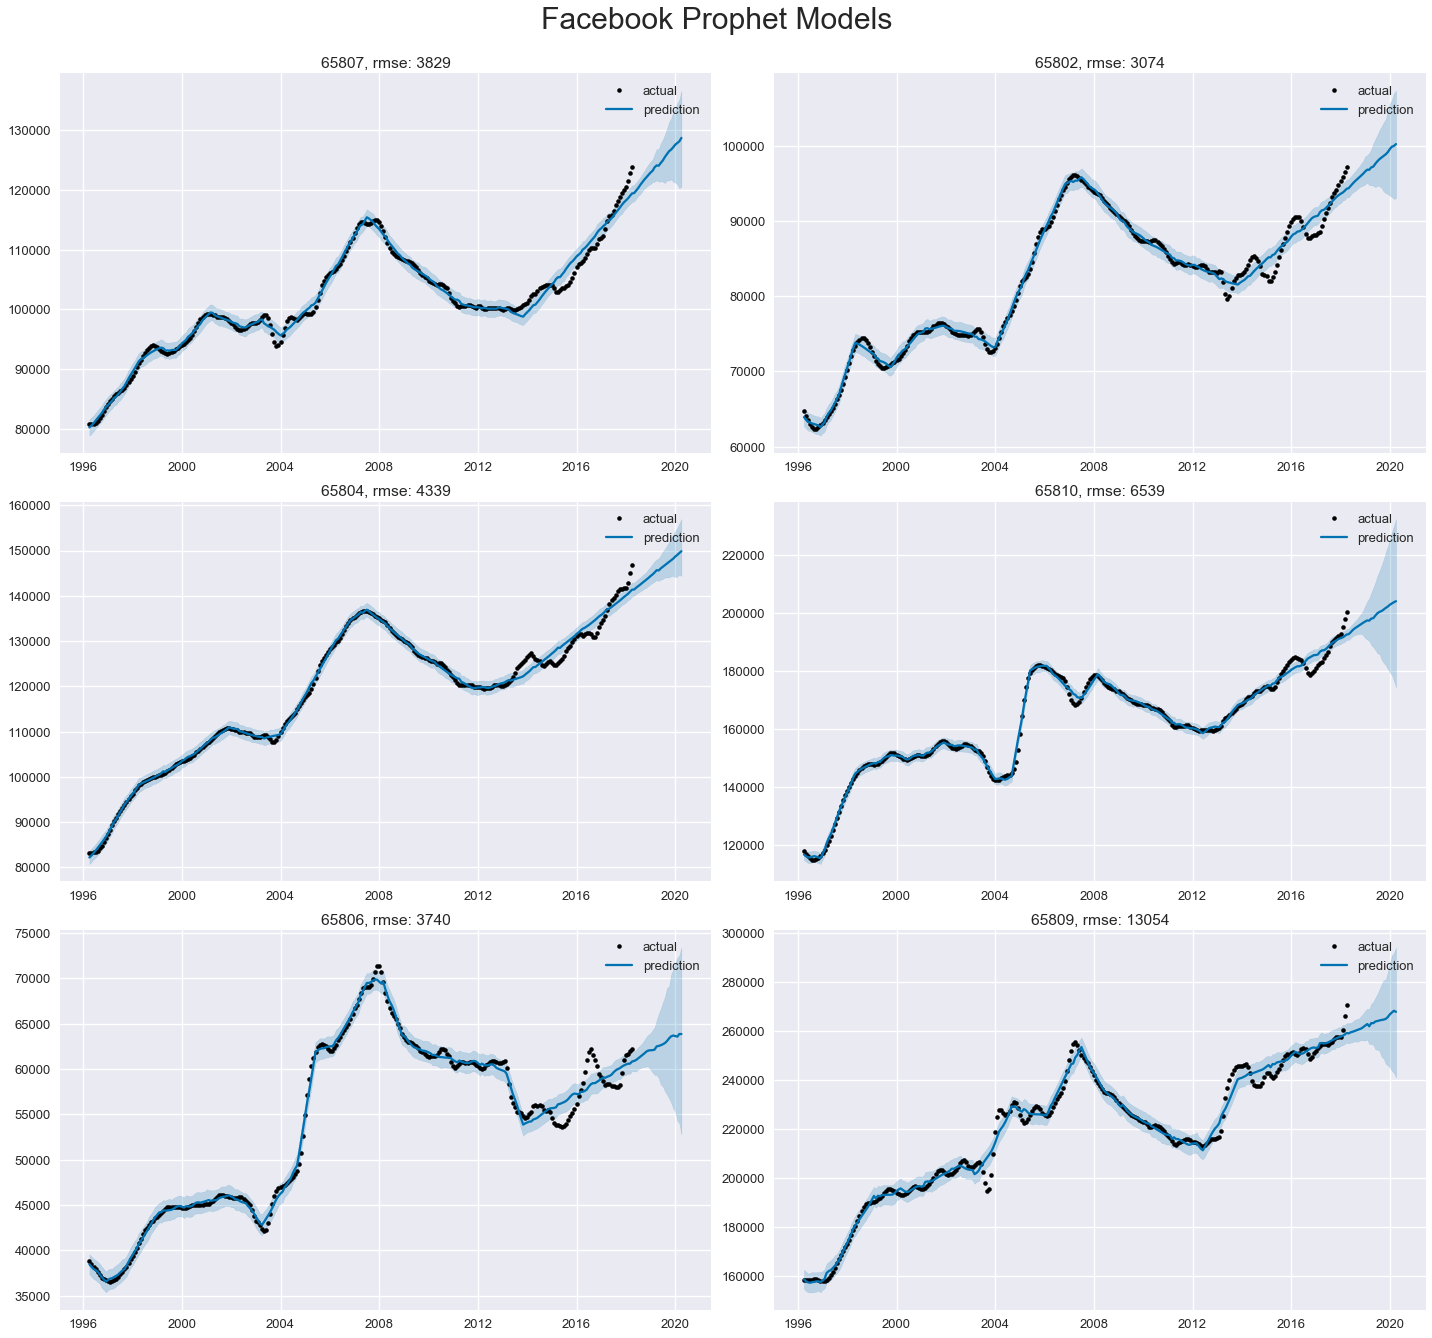

In [12]:
forecasts = {}
fig = plt.figure(figsize=(20, 18))
axs = fig.subplots(3, 2).flatten()

for i, col in enumerate(tuning_results.index):
    ts = springfield[['ds', col]].rename(columns={col:'y'})
    ts_model = Prophet(**tuning_results.drop(columns='rmse').iloc[i].to_dict())
    ts_model.fit(ts)
    forecast = ts_model.predict(ts_model.make_future_dataframe(periods=24, freq='MS'))
    
    df_cv = cross_validation(ts_model, initial='15 y', period='180 days', horizon = '1 y')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmse = df_p['rmse'].values[0]
    
    forecasts[col] = forecast[['ds', 'yhat']].rename(columns={'ds':'date', 'yhat':col}).set_index('date')
    
    ax = axs[i]
    ax.plot('ds', col, 'k.', data=springfield)
    ax.plot(forecast['ds'], forecast['yhat'], ls='-', c='#0072B2')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#0072B2', alpha=0.2)
    ax.set_title(f'{col}, rmse: {int(rmse)}')
    ax.legend(labels=('actual', 'prediction'))

plt.suptitle('Facebook Prophet Models', y=1.03, fontsize=30)
plt.tight_layout()
plt.savefig('visualizations/prophet-models.png')
plt.show()

In [19]:
prophet_forecasts = {i:k.values.flatten()[-24:] for i, k in forecasts.items()}
prophet_forecasts['date'] = list(forecasts.values())[0].index[-24:]
prophet_final_df = pd.DataFrame(prophet_forecasts)
prophet_final_df.set_index('date', inplace=True)
prophet_final_df.tail()

,65807,65802,65804,65810,65806,65809
date,,,,,,
2019-12-01,127070.233087,99174.442951,148194.536870,202212.222251,63707.912363,265616.752851
2020-01-01,127517.386168,99590.750794,148669.931055,202847.907779,63653.907614,266730.304083
2020-02-01,127809.488868,99904.390392,149031.206487,203300.825200,63584.750557,267542.519975
2020-03-01,128064.701521,100012.391682,149444.405223,203721.232062,63874.360932,268200.753897
2020-04-01,128651.011816,100255.124506,149841.237435,204064.850838,63873.122266,267778.466056


In [20]:
prophet_final_df.to_csv('data/prophet_predictions.csv')